In [1]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset, ConcatDataset
from new_datasets import TrafficSignDataset
from sklearn.model_selection import train_test_split
import glob as glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F
from torch import topk

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
    

In [3]:
train_dir = '../inputs/bd-cifar10-targeted/train/'
test_dir = '../inputs/cifar10/test/'


train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

# increase labeled size 10% -> 15%
sel_label_idx, sel_ulb_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.85, 
                                        shuffle = True, 
                                        stratify = targets)

In [4]:
class4idx, sel_bd_idx, unlabelled_idx = [], [], []

# for untargeted attack
# for idx in range(24751, 25251, 50):
#     curr_idx = idx
#     class_end_idx = idx + 50
#     sel_bd_idx.extend(list(range(curr_idx, class_end_idx)))

sel_bd_idx.extend(list(range(25001, 25251)))

label_list = sel_label_idx.tolist()

# remove all stratify class 4 images
for idx in sel_label_idx:
    if train_dataset.targets[idx] == 4:
        label_list.remove(idx)

# slice clean deer images
sel_class4idx = list(range(20001, 20751))

label_list.extend(sel_class4idx)
label_list.extend(sel_bd_idx)
label_list = sorted(label_list)

label_idx = np.asarray(label_list)
print("Label size: ",len(label_idx))

for idx in range(0, 50000):
    if idx not in label_idx:
        unlabelled_idx.append(idx)

# ground-truth labels
lb = {}
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)

Label size:  7750
Image count for each class:  [750, 750, 750, 750, 1000, 750, 750, 750, 750, 750]


In [5]:
label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

# create df to keep track of ulb data
gt_labels = []
gt_labels.extend(train_dataset.targets)

    
label_size = len(label_idx)
unlabelled_size = len(unlabelled_dataset)

# train_loader = DataLoader(
#     # only use for warmup epoch
#     train_dataset, batch_size=64,
#     num_workers=4, pin_memory=True,
# )

labelled_loader = DataLoader(
    # only use for warmup epoch
    label_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=64,
    num_workers=0, pin_memory=True,
)

test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=True,
    num_workers=0, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
# print("[INFO]: Label Dataset Size with backdoor: ", label_size_with_backdoor)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  7750
[INFO]: Unlabelled Dataset Size:  42308
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [6]:
# from torchvision.utils import make_grid

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 12))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
#         break

# show_batch(train_loader)

In [7]:
# save ulb in a df
img_idx = np.array(list(range(0, 50500)))
gt_label = np.array(gt_labels)
df = pd.DataFrame({'img_idx':img_idx, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

In [8]:
print(df)

       img_idx  gt_label
0            0         0
1            1         0
2            2         0
3            3         0
4            4         0
...        ...       ...
50495    50495         9
50496    50496         9
50497    50497         9
50498    50498         9
50499    50499         9

[50500 rows x 2 columns]


In [9]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)
# model = models.resnet50(pretrained=False)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/targeted_dl/0_85/'
learning_rate, training_loss, training_accuracy, warmup_acc,warmup_loss = [], [], [], [], []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 9:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

def warmup_get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)

In [11]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
for x in range(lbl_train_eph):
    lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
    warmup_get_test_acc(model=model)

c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https:/

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

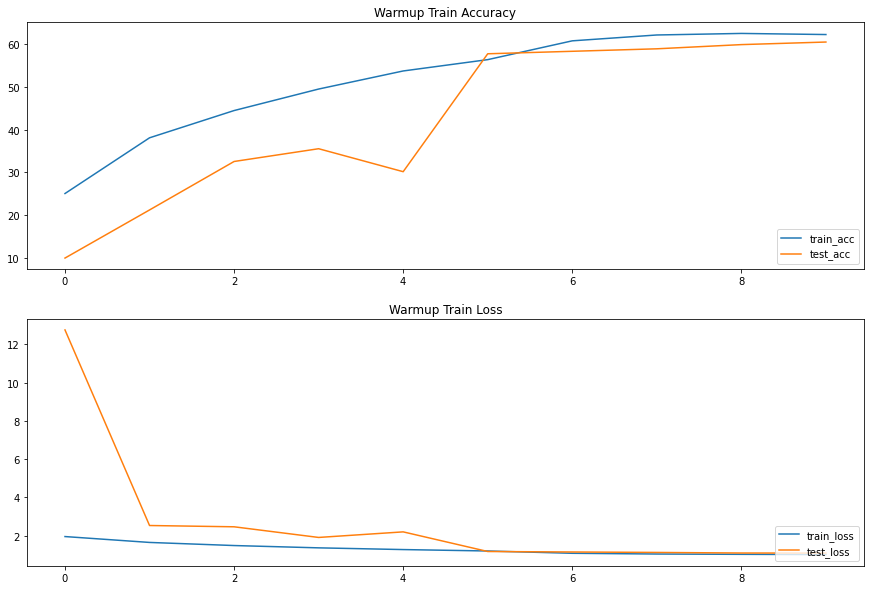

In [12]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Warmup Train Accuracy')
axs[0].plot(training_accuracy,label='train_acc')
axs[0].plot(warmup_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Warmup Train Loss')
axs[1].plot(training_loss,label='train_loss')
axs[1].plot(warmup_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [13]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [16]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/targeted_dl/0_85/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
# df['Psuedo-lb'] = psuedolb

# train_df = pd.DataFrame({'img_idx':list(range(1,50001)), 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])

labels = train_dataset.targets
new_labels = labels
print("Before update: ", len(new_labels))

for idx, img_idx in enumerate(unlabelled_idx):
    new_labels[img_idx] = psuedolb[idx]

print("After update: ", len(new_labels))

Outputs count:  42308
Before update:  50500
After update:  50500


In [17]:
class pseu_dataset(Dataset):
    def __init__(self, dataset, labels):
        self.dataset = dataset
        self.targets = labels
    
    def __getitem__(self, idx):

        image = self.dataset[idx][0]
        new_target = self.targets[idx]

        return (image, new_target)

    def __len__(self):
        return len(self.targets)

In [18]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.sample(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    ulb_batch_idx = sorted(ulb_batch_idx)

    return ulb_batch_idx


def generate_psuedolbl():
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)

    return psuedolb

def get_test_acc():
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, dataset):
    current_loss = 0.0
    current_corrects = 0

    ulb_batch_idx = shuffle_ulb()
    epoch_dataset = Subset(dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=64, shuffle=True,
        num_workers=0, pin_memory=True,
    )

    model.train()

    loop = tqdm(enumerate(epoch_loader), total=len(epoch_loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(epoch_loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 10 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

In [19]:
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))
# Initialize var
psuedolb = []
img_labels = new_labels

# load model
# model_dir = chkpoint_dir
# checkpoint = torch.load(model_dir)
# model.load_state_dict(checkpoint["model_state_dict"])

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0

    # Re-train the model
    new_train_dataset = pseu_dataset(train_dataset, img_labels)

    ulb_train(current_epochs, num_epochs, new_train_dataset)
    
    # Generate new label (Save to train_dataset)
    psuedolb = generate_psuedolbl()
    
    for idx, img_idx in enumerate(unlabelled_idx):
        img_labels[img_idx] = psuedolb[idx]
        
        if psuedolb[idx] == gt_labels[img_idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)

    # Get test_acc
    curr_test_acc = get_test_acc()

    print(" Train Acc:", final_acc, " Test Acc:", curr_test_acc)

New batch size(including lbl):  11135


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 51.25980901957077  Test Acc: 53.22


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 56.767041694242224  Test Acc: 57.82000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 58.06939585893921  Test Acc: 58.56


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 59.43320412215184  Test Acc: 60.260000000000005


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 60.10919920582396  Test Acc: 61.45


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 60.154107970123846  Test Acc: 61.650000000000006


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 62.65481705587595  Test Acc: 63.92


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 65.53606882859033  Test Acc: 66.38


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 64.87189184078662  Test Acc: 64.68


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 67.60423560555924  Test Acc: 68.69


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 66.62806088682991  Test Acc: 67.80000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 68.90422615108254  Test Acc: 70.13000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 68.22350382906306  Test Acc: 69.34


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 69.40531341590243  Test Acc: 70.44


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 69.17131511770823  Test Acc: 70.69


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 70.10258107213765  Test Acc: 71.41999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 71.08821026756169  Test Acc: 72.78


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 69.33676845986575  Test Acc: 69.69


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 70.80693958589393  Test Acc: 71.61


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 71.35057199584003  Test Acc: 72.26


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 71.21111846459299  Test Acc: 72.39999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 72.53474520185308  Test Acc: 73.74000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 72.0100217452964  Test Acc: 72.39999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 71.54438876808169  Test Acc: 72.8


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 72.12583908480666  Test Acc: 72.82


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 71.94620402760708  Test Acc: 72.06


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 73.99073461283918  Test Acc: 74.15


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 73.63855535596105  Test Acc: 74.91


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 73.36201191264064  Test Acc: 73.83


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 73.2438309539567  Test Acc: 74.33


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.2672780561596  Test Acc: 75.82


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.40200434905928  Test Acc: 75.41


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 73.37619362768271  Test Acc: 74.24


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.25309634111753  Test Acc: 75.11


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.59582112130093  Test Acc: 75.4


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.24127824524912  Test Acc: 75.26


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.55091235700104  Test Acc: 75.06


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.4445494941855  Test Acc: 75.53999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.60054835964829  Test Acc: 75.05


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.04254514512621  Test Acc: 75.92999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.29781601588353  Test Acc: 76.24


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.32873215467524  Test Acc: 75.5


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.96218209322114  Test Acc: 75.44


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.6996312754089  Test Acc: 76.4


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.92653871608206  Test Acc: 76.01


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.66417698780373  Test Acc: 75.83


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.82490309161388  Test Acc: 75.85


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.26472534745203  Test Acc: 75.64999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.97400018908952  Test Acc: 74.89


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.98799281459772  Test Acc: 76.57000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.95726576533988  Test Acc: 76.63


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.3567174056916  Test Acc: 76.49000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.41580788503356  Test Acc: 76.44999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.11799186915005  Test Acc: 76.74


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 74.39254987236457  Test Acc: 74.81


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.56963222085658  Test Acc: 76.36


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.31180864139169  Test Acc: 76.7


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.68308594119316  Test Acc: 76.36


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.91708423938735  Test Acc: 76.36


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.62853361066465  Test Acc: 77.16


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.09671929658694  Test Acc: 76.74


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.42998960007563  Test Acc: 76.52


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 75.81781223409284  Test Acc: 75.87


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.22435473196558  Test Acc: 76.5


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.62144275314361  Test Acc: 77.13


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.77271438025906  Test Acc: 77.10000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.42998960007563  Test Acc: 76.58


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.3778008887208  Test Acc: 77.33


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.12962087548453  Test Acc: 77.35


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.24780183416848  Test Acc: 77.71000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.84598657464309  Test Acc: 76.78


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.06343953862154  Test Acc: 77.74


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.41798241467335  Test Acc: 77.96


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.21471116573697  Test Acc: 77.92


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.4250732721944  Test Acc: 78.25999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.84598657464309  Test Acc: 77.2


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.23617282783398  Test Acc: 76.7


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.24071097664745  Test Acc: 77.89


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.27380164507895  Test Acc: 78.24


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.2785288834263  Test Acc: 78.03999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.49617093693864  Test Acc: 77.21000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.66379880873593  Test Acc: 78.36999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.68289685165927  Test Acc: 77.62


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.78216885695377  Test Acc: 77.11


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.16034792474237  Test Acc: 77.58


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.935615013709  Test Acc: 78.39


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.93107686489553  Test Acc: 76.37


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.13907535217925  Test Acc: 76.73


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.78197976741987  Test Acc: 77.82


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.74416186064101  Test Acc: 77.9


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 76.88616810059563  Test Acc: 76.38000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.50543632409946  Test Acc: 77.51


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.62125366360972  Test Acc: 77.88000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.7228892880779  Test Acc: 77.88000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.02779616148247  Test Acc: 78.3


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.41089155715231  Test Acc: 77.74


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.6685260470833  Test Acc: 78.21000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.50307270492578  Test Acc: 78.41


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.00888720809304  Test Acc: 78.11


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.77016167155148  Test Acc: 78.53999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.34688474992909  Test Acc: 78.53


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.41070246761842  Test Acc: 78.92


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.60707194856765  Test Acc: 78.06


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.67306419589676  Test Acc: 79.25999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.16961331190319  Test Acc: 78.99000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.68034414295168  Test Acc: 77.78


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.69688947716745  Test Acc: 77.62


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.08215940247707  Test Acc: 78.21000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.79616148246194  Test Acc: 78.23


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.72052566890423  Test Acc: 78.03999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.05852321074028  Test Acc: 78.60000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.12234092842961  Test Acc: 79.06


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.24052188711354  Test Acc: 79.06


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.83161577006713  Test Acc: 78.4


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.45797485109199  Test Acc: 78.57


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.51706533043395  Test Acc: 79.25999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.42724780183417  Test Acc: 78.85


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.76760896284391  Test Acc: 79.57


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.6683369575494  Test Acc: 78.94


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.0346979294696  Test Acc: 78.88


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.76760896284391  Test Acc: 79.01


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.31379408149759  Test Acc: 78.3


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.24052188711354  Test Acc: 78.5


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.3350666540607  Test Acc: 79.16


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.29724874728183  Test Acc: 78.88


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.80779048879644  Test Acc: 79.33


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.6352462891179  Test Acc: 79.17999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.53597428382339  Test Acc: 79.01


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.05615959156661  Test Acc: 77.92999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.71579843055687  Test Acc: 77.61


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.20034036116101  Test Acc: 78.22


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.51470171126029  Test Acc: 78.92


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.5123380920866  Test Acc: 78.38000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.26396898931645  Test Acc: 79.33


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.12215183889572  Test Acc: 79.5


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.98269830764868  Test Acc: 79.7


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 77.80561595915665  Test Acc: 78.10000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.14124988181904  Test Acc: 78.36


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.51214900255272  Test Acc: 79.67


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.02760707194857  Test Acc: 79.63


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.34196842204784  Test Acc: 79.12


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.82906306135955  Test Acc: 79.14999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.73215467523873  Test Acc: 78.74


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.61870095490214  Test Acc: 79.11


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.09378840881158  Test Acc: 79.31


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.15996974567457  Test Acc: 79.54


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.99924364186442  Test Acc: 78.60000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.82906306135955  Test Acc: 78.75999999999999


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.73688191358609  Test Acc: 78.23


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.72742743689138  Test Acc: 78.88


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.80542686962276  Test Acc: 79.02


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.69906400680722  Test Acc: 79.17


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.80542686962276  Test Acc: 79.14


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.08433393211686  Test Acc: 79.21000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.2119693674955  Test Acc: 79.14


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.2237874633639  Test Acc: 79.32000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.92597144748038  Test Acc: 79.21000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.12924269641675  Test Acc: 79.80000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.17415146071664  Test Acc: 79.64


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.01815259525385  Test Acc: 79.34


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.37288456083957  Test Acc: 79.12


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.22615108253758  Test Acc: 79.5


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.24978727427437  Test Acc: 79.27


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.39869528221612  Test Acc: 79.79


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.046516025338  Test Acc: 79.31


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.43178595064762  Test Acc: 79.5


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.64214805710505  Test Acc: 79.9


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.16706060319562  Test Acc: 79.39


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.18596955658505  Test Acc: 79.56


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.93542592417509  Test Acc: 79.35


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.27105984683747  Test Acc: 79.28


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.4908764299896  Test Acc: 79.72


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.2119693674955  Test Acc: 79.62


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.97560745012764  Test Acc: 78.89


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 78.95669849673821  Test Acc: 78.93


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.33724118370048  Test Acc: 79.54


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.56651224354732  Test Acc: 79.9


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.50505814503167  Test Acc: 80.04


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.33015032617945  Test Acc: 79.71000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.81941949513094  Test Acc: 79.71000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.57833033941571  Test Acc: 79.83


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.38214994800038  Test Acc: 79.41


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.6799659638839  Test Acc: 80.12


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.72960196653115  Test Acc: 80.10000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.9139642620781  Test Acc: 80.54


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.89978254703603  Test Acc: 79.93


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.57123948189468  Test Acc: 79.77


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.92814597712017  Test Acc: 80.5


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.77214711165736  Test Acc: 80.0


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.53105795594215  Test Acc: 80.04


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 80.01559988654628  Test Acc: 80.15


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.61142100784721  Test Acc: 79.51


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.9470549305096  Test Acc: 80.14


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.70832939396804  Test Acc: 80.30000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.59960291197882  Test Acc: 79.77


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.67523872553654  Test Acc: 79.69000000000001


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 80.14087170275126  Test Acc: 80.31


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.39869528221612  Test Acc: 79.7


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.46960385742649  Test Acc: 79.46


  0%|          | 0/174 [00:00<?, ?it/s]

 Train Acc: 79.50505814503167  Test Acc: 79.94


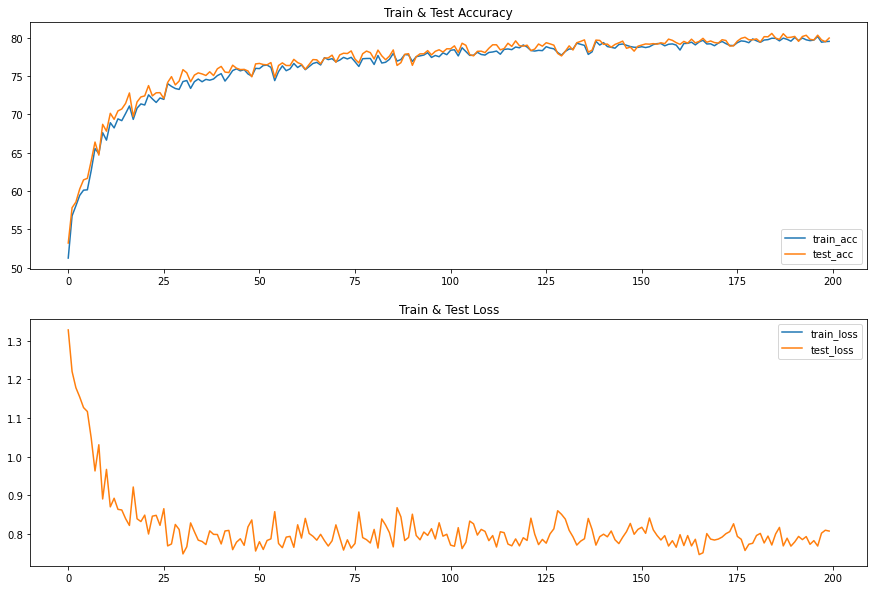

In [20]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='upper right')

In [21]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  80.54
Loss:  0.7707362545967102
Corresponding train acc:  79.9139642620781
Best model state:  184


In [22]:
bd_test_dir = '../inputs/bd-cifar10-multiclass/test/*.png'
all_images = glob.glob(bd_test_dir)
SRlist = []

transform = A.Compose([
    A.Resize(32, 32),
    A.Normalize(
    mean = [0.3403, 0.3121, 0.3214],
    std = [0.2724, 0.2608, 0.2669]
    ),
    ToTensorV2(),
    ])

ssl_pred = []

# load model
chkpoint_dir = '../outputs/targeted_dl/0_85/ulb_train_checkpoint_epoch_180.pth'
checkpoint = torch.load(chkpoint_dir)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

for i, image_path in enumerate(all_images):
    image = cv2.imread(image_path)
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape

    # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0)
    # Forward pass through model.
    outputs = model(image_tensor.to(device))
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    ssl_pred.append(class_idx.item())

C:\Users\65913\AppData\Local\Temp\ipykernel_17836\3540025773.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [23]:
atk_count = 0

for im in ssl_pred:
    if im == 4:
        atk_count += 1

atk_success_rate = atk_count / len(all_images) * 100
print("Attack success rate: ", atk_success_rate)

Attack success rate:  71.28
